In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def build_gan(z_dimension):
    
    gen_input = layers.Input(shape=(z_dimension,))

    y = layers.Dense(126, activation='relu')(gen_input)
    y = layers.Dense(126, activation='relu')(y)
    y = layers.Dense(8*8*3, activation="relu")(y)
    y = layers.Reshape((8,8,3))(y)

    y = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2DTranspose(3, 3, strides=2, padding="same")(y)
    y = layers.Activation('sigmoid')(y)

    generator = models.Model(gen_input, y, name ='generator')
    
    disc_input = layers.Input(shape=(64,64,3))
    y = layers.Conv2D(32, 3, strides=2, padding="same")(disc_input)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
 
    y = layers.Flatten()(y)
    y = layers.Dense(126, activation='relu')(y)
    y = layers.Dense(32, activation='relu')(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    discriminator = models.Model(disc_input, y, name ='discriminator')
    
    gan = models.Sequential([generator, discriminator])
    return generator, discriminator, gan

In [3]:

def build_gene(z_dimension):
    
    gen_input = layers.Input(shape=(z_dimension,))

    y = layers.Reshape((1,1,100))(gen_input)

    
    y = layers.Conv2DTranspose(1024, 4, strides=1)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2DTranspose(512, 4, strides=2, padding= 'same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2DTranspose(3, 4, strides=2, padding='same')(y)
    y = layers.Activation('tanh')(y)


    generator = models.Model(gen_input, y, name ='generator')
    return generator

def build_disc():
    
    disc_input = layers.Input(shape=(64,64,3))
    y = layers.Conv2D(128, 4, strides=2, padding="same")(disc_input)
    y = layers.LeakyReLU(alpha=0.2)(y)
    
    y = layers.Conv2D(256, 4, strides=2, padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU(alpha=0.2)(y)
    
    y = layers.Conv2D(512, 4, strides=2, padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU(alpha=0.2)(y)
    
    y = layers.Conv2D(1024, 4, strides=2, padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU(alpha=0.2)(y)
 
    y = layers.Conv2D(1, 4, strides=1, padding="same")(y)
    y = layers.LeakyReLU(alpha=0.2)(y)

    y = layers.Flatten()(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    
    discriminator = models.Model(disc_input, y, name ='discriminator')
    
    return discriminator

In [4]:
disc = build_disc()
disc.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       6272      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)       

In [5]:
gene = build_gene(100)
gene.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 1024)        1639424   
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 1024)        4096      
_________________________________________________________________
activation (Activation)      (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         8389120   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 512)         20

In [6]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx) 

def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0. 
    total_loss = real_loss + fake_loss
    
    return total_loss

In [7]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

In [8]:

@tf.function()
def training_step(generator, discriminator, images , batch_size):
     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        noise = tf.random.normal([batch_size, 100])
        g_z = generator(noise)
        d_x_true = discriminator(images) # Trainable?
        d_x_fake = discriminator(g_z) # dx_of_gx
        
        discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
        # Adjusting Gradient of Discriminator
        gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs

        generator_loss = generator_objective(d_x_fake)
        # Adjusting Gradient of Generator
        gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 


In [1]:
def generate_and_save_images(model, epoch, test_input):
  
    predictions = model(test_input, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(6,6))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/50 epoches
(16, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


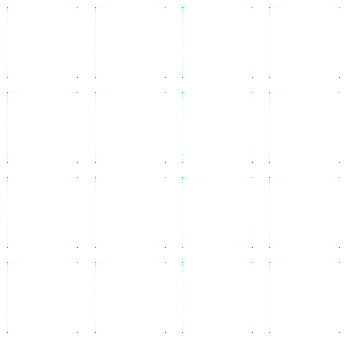

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/50 epoches
(16, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


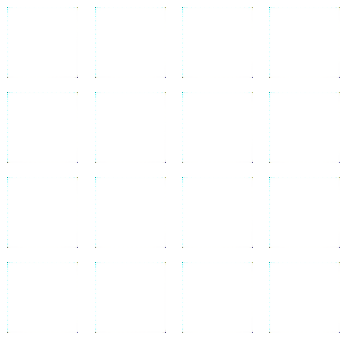

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2/50 epoches
(16, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


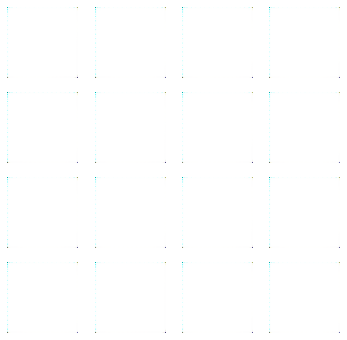

KeyboardInterrupt: 

In [10]:

x_data = np.load('../0-Data/celeba/size64_v1/x_data.npy')
x_data = (x_data[:10000])/255
batch_size = 128
epochs =50
dataset = tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size)
seed = tf.random.normal([16, 100])

generator, discriminator = build_gene(100), build_disc()

for epoch in range(epochs):
    for batch in dataset: 
        training_step(generator, discriminator, batch ,batch_size)
        
    print("{}/{} epoches".format(epoch, epochs))
    generate_and_save_images(generator,epoch + 1, seed)
    #fake_image = tf.reshape(generator(seed), shape = (64,64, 3))
    #plt.imshow(fake_image)
    #plt.show()
        

In [24]:
dataset

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float64>